## <center>Simple EDA and feature engineering or how to make top200 without boosting, eli5/shap and other tricks

*rus_intro*

В этом проекте мы будем решать задачу идентификации пользователя по его поведению в сети Интернет. Это сложная и интересная задача на стыке анализа данных и поведенческой психологии. В качестве примера, компания Яндекс решает задачу идентификации взломщика почтового ящика по его поведению. В двух словах, взломщик будет себя вести не так, как владелец ящика: он может не удалять сообщения сразу по прочтении, как это делал хозяин, он будет по-другому ставить флажки сообщениям и даже по-своему двигать мышкой. Тогда такого злоумышленника можно идентифицировать и "выкинуть" из почтового ящика, предложив хозяину войти по SMS-коду. Этот пилотный проект описан в статье на Хабрахабре. Похожие вещи делаются, например, в Google Analytics и описываются в научных статьях, найти можно многое по фразам "Traversal Pattern Mining" и "Sequential Pattern Mining".


Мы будем решать похожую задачу: по последовательности из нескольких веб-сайтов, посещенных подряд один и тем же человеком, мы будем идентифицировать этого человека. Идея такая: пользователи Интернета по-разному переходят по ссылкам, и это может помогать их идентифицировать (кто-то сначала в почту, потом про футбол почитать, затем новости, контакт, потом наконец – работать, кто-то – сразу работать).

Будем использовать данные из статьи "A Tool for Classification of Sequential Data".

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import pickle
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve, auc
import scipy as sp
import eli5
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer, CountVectorizer

In [72]:
# для сабмитов
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
# считываем train, test
## путь изменить на свой при необходимости
train_df = pd.read_csv('../train_sessions.csv',
                       index_col='session_id')
test_df = pd.read_csv('../test_sessions.csv',
                      index_col='session_id')

# Сортировка по времени, т.к. данные привязаны ко времени
train_df = train_df.sort_values(by='time1')

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0


In [4]:
sites = ['site%s' % i for i in range(1,11)]
times = ['time%s' % i for i in range(1, 11)]
#приводим время к datetime формату
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

In [5]:
#заполняем пропуски нулями
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [6]:
train_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [19]:
# Посмотрим на распределение отн. целевой переменной
train_df['target'].value_counts(normalize=False)

0    251264
1      2297
Name: target, dtype: int64

In [ ]:
#выборка экстремально несбалансированная, т.о. наша задача - поиск аномалий.

In [7]:
y_train = train_df['target']
df = pd.concat([train_df.drop('target', axis=1), test_df])
full_sites = df[sites]
idx_split = train_df.shape[0]

In [8]:
sites_flatten = full_sites.values.flatten()
sites_flatten

array([  56,   55,    0, ..., 1098, 1098, 1098])

In [9]:
full_sites_sparse = sp.sparse.csr_matrix(([1]*sites_flatten.shape[0], 
                                          sites_flatten, 
                                          range(0, sites_flatten.shape[0] + full_sites.shape[1],full_sites.shape[1])))[:, 1:]

In [10]:
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]
X_test = full_sites_sparse[idx_split:, :]

In [11]:
v = TfidfVectorizer(stop_words=[' ','  ',','], ngram_range=(1, 5), max_features=20000, max_df=0.5)

In [12]:
full_sites_str = ["".join(str(sites)) for sites in df[sites].values]
full_sites_str

['[56 55  0  0  0  0  0  0  0  0]',
 '[56 55 56 55  0  0  0  0  0  0]',
 '[946 946 951 946 946 945 948 784 949 946]',
 '[945 948 949 948 945 946 947 945 946 946]',
 '[947 950 948 947 950 952 946 951 946 947]',
 '[952 947 953 946 947 946 953 955 946 947]',
 '[ 953  947  946  953  955  947  953  946  953 1033]',
 '[946 947 954 953 946 954 946 956 957 956]',
 '[946 956 946 946 955 954 946 946 946 948]',
 '[948 946 948 784  49  53 812 982  52  52]',
 '[ 52  52  52 747 747 747  23 747 568  23]',
 '[ 513 1116  747   23  747  747   29   49   52   21]',
 '[4222 3358 4222 3356 4222 3870   21 3870 3358   21]',
 '[38667   181    23   181 38667    23   182   181 38667    55]',
 '[ 56  55 679 676 814  22  39 815 752  50]',
 '[ 570   23   21 3356   48  222  570  513 1379   21]',
 '[820 820 980  49  56  55  49 784 222  50]',
 '[48 56 55 55  0  0  0  0  0  0]',
 '[5898 5898 5794   21 5794 5794   21  182   23  181]',
 '[2570 2570   21   21 1102 1102   23  570  707   21]',
 '[  22   39 1102   21 1102 11

In [13]:
tfidf = v.fit_transform(full_sites_str)

In [14]:
tfidf

<336358x20000 sparse matrix of type '<class 'numpy.float64'>'
	with 4478690 stored elements in Compressed Sparse Row format>

### Features

In [16]:
#фичи, основанные на сайтах
#можно извлечь и больше, а лучше юзать обратный маппинг сайтов, как Yorko делал в последнем кернеле. В том случае можно также сделать обобщения на случаи с www и без, посчитать доменные имена гораздо точнее и тд и тп
hosts = pd.read_pickle('../site_dic.pkl')
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # rename index for the future merge
df = pd.merge(df, hosts, how='left', on='site1')

In [20]:
#немножко "флагов"
df['big_site'] = df['len'].apply(lambda x: x > 5).astype(np.int8)
df['typical_site'] = df['len'].apply(lambda x: x == 3).astype(np.int8)
df['typical_domain'] = df['domain'].map(lambda x: x in ('com', 'fr', 'net', 'uk', 'org', 'tv')).astype(np.int)

In [18]:
#фичи, основанные на длительности сессий
df['min'] = df[times].min(axis=1)
df['max'] = df[times].max(axis=1)
df['seconds'] = ((df['max'] - df['min']) / np.timedelta64(1, 'ms'))
df['minutes'] = ((df['max'] - df['min']) / np.timedelta64(1, 'm')).round(2)
df['short'] = df['minutes'].map(lambda x: x < 0.8).astype(np.int8)
df['long'] = df['minutes'].map(lambda x: x >= 0.8).astype(np.int8)
df.drop(['min','max'], inplace=True, axis=1)

In [23]:
#временные фичи
df['YearMonth'] = df['time1'].apply(lambda x:x.strftime('%Y%m')).astype('int64')
#df['Year'] = df['time1'].apply(lambda x:x.strftime('%Y')).astype('int64') --
#большая корреляция по Пирсону с YearMonth (очевидно), не зашло
df['Month'] = df.time1.dt.strftime('%m').astype('int64')
df['YearDay'] = df['time1'].apply(lambda x:x.strftime('%j')).astype('int64')
df['is_weekend'] = df['time1'].apply(lambda x: 1 if x.date().weekday() in (5,6) else 0)
df['wed'] = df['time1'].apply(lambda x: 1 if x.date().weekday() in [2] else 0)
df['Hour'] = df.time1.apply(lambda x:x.strftime('%H')).astype('int64')
#df['Week'] = df['time1'].dt.strftime('%W').astype('int64') -- большая корреляция по Пирсону с YearDay, не зашло
df['Day_of_week'] = df['time1'].dt.strftime('%w').astype('int64')

In [25]:
#еще немножко "флагов"
df['Day'] = df.Hour.apply(lambda x:1 if x in range(12,19) else 0)
df['Eve'] = df.Hour.apply(lambda x:1 if x in range(19,24) else 0)
df['Night'] = df.Hour.apply(lambda x:1 if x in range(24,6) else 0) 
#несмотря на то, что график ничего не показывает и фьюч импортансы показывают нули, 
#присутствие флага дает прирост на LB. У некоторых людей прироста нет. Stranger things
df['Morning'] = df.Hour.apply(lambda x:1 if x in range(6,12) else 0)

In [27]:
df['is_summer'] = df['Month'].apply(lambda x: 1 if x in (6, 7, 8) else 0)

In [28]:
enc = OneHotEncoder()
hour = enc.fit_transform(df[['Hour']].as_matrix())
dayweek = enc.fit_transform(df[['Day_of_week']].as_matrix())
yday = enc.fit_transform(df[['YearDay']].as_matrix())
ym = enc.fit_transform(df[['YearMonth']].as_matrix())
lenn = enc.fit_transform(df[['len']].as_matrix())

In [29]:
features_to_scale = [
    'seconds',
]
df[features_to_scale] = StandardScaler().fit_transform(df[features_to_scale])

In [30]:
full_feat = sp.sparse.hstack([tfidf, 
                              dayweek,
                              hour,
                              yday, 
                              ym, 
                              lenn,
                              df.seconds.values.reshape(-1, 1), 
                              df.short.values.reshape(-1, 1),
                              df.long.values.reshape(-1, 1),
                              df.big_site.values.reshape(-1, 1),
                              df.typical_site.values.reshape(-1, 1),
                              df.typical_domain.values.reshape(-1, 1),
                              df.is_summer.values.reshape(-1, 1), 
                              df.wed.values.reshape(-1, 1),
                              df.is_weekend.values.reshape(-1, 1), 
                              df.Night.values.reshape(-1, 1), 
                              df.Day.values.reshape(-1, 1), 
                              df.Morning.values.reshape(-1, 1), 
                              df.Eve.values.reshape(-1, 1)]).tocsr()

In [31]:
Xfull_train = full_feat[:idx_split, :]
Xfull_test = full_feat[idx_split:, :]

In [32]:
# time awared CrossValidation
# поскольку у нас данные зависят от времени, стандартный кросс-фит просто перемешает всё в кучу и
# предсказания будут не точными. Для корректной кросс-валидации используем TimeSeriesSplit
time_split = TimeSeriesSplit(n_splits=10)

In [33]:
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]

[((23051,), (23051,)),
 ((46102,), (23051,)),
 ((69153,), (23051,)),
 ((92204,), (23051,)),
 ((115255,), (23051,)),
 ((138306,), (23051,)),
 ((161357,), (23051,)),
 ((184408,), (23051,)),
 ((207459,), (23051,)),
 ((230510,), (23051,))]

In [34]:
logit = LogisticRegression(solver='liblinear', C=3, penalty='l2', random_state=17)
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

In [35]:
%%time

cv_scores = cross_val_score(logit, Xfull_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1)

CPU times: user 117 ms, sys: 241 ms, total: 357 ms
Wall time: 14.1 s


In [69]:
cv_scores, cv_scores.mean()

(array([0.68384237, 0.91764399, 0.92235186, 0.96436976, 0.92522363,
        0.98607496, 0.86552679, 0.96986813, 0.91919592, 0.98777413]),
 0.9141871528502774)

In [ ]:
# кривые валидации и обучения

In [76]:
X_tra , X_valid , y_tra , y_valid = train_test_split(Xfull_train,y_train,test_size=0.2)
logit.fit (X_tra, y_tra)
preds_lr = logit.predict_proba (X_valid)[:, 1]

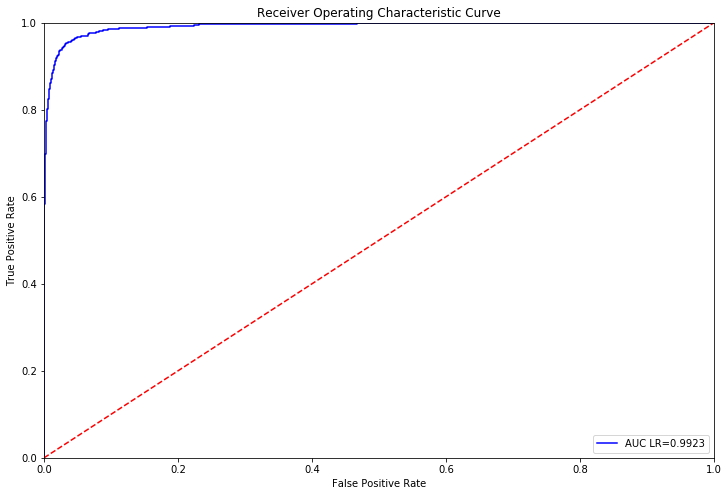

In [78]:
fpr_lr,tpr_lr,threshold=roc_curve(y_valid,preds_lr)
roc_auc_lr = auc(fpr_lr,tpr_lr)
plt.figure(figsize=(12,8))
plt.title('Receiver Operating Characteristic Curve')
plt.plot(fpr_lr, tpr_lr,'b', label='AUC LR=%0.4f'%roc_auc_lr)
plt.legend(loc='lowerright')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

In [ ]:
#потом был перебор фич вручную, GridSearchCV для гиперпараметров векторайзера, 
#он же для гиперпараметров LR, 
#(params = {
#    'C': np.logspace(-2, 2, 10),
#    'penalty': ['l1','l2']
#}) и все в таком духе
#переобученные xgboost-ы с hyperopt-ом и прочее. 

In [70]:
logit.fit(Xfull_train, y_train)

LogisticRegression(C=3, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=17, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [73]:
logit_test_pred = logit.predict_proba(Xfull_test)[:, 1]
write_to_submission_file(logit_test_pred, 'submission__.csv') #0.95736

In [ ]:
#Ниже немного показательных графиков с хоть чуть-чуть нестандартными идеями
#(т.е кроме того, что Alice активней днём, активней по выходным, менее активна летом, ночью никто не сидит)

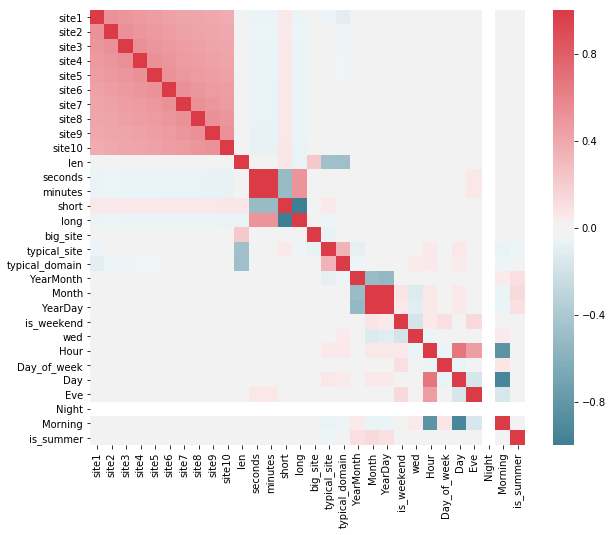

In [38]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [39]:
df.drop(['minutes','Month'], axis=1, inplace=True)

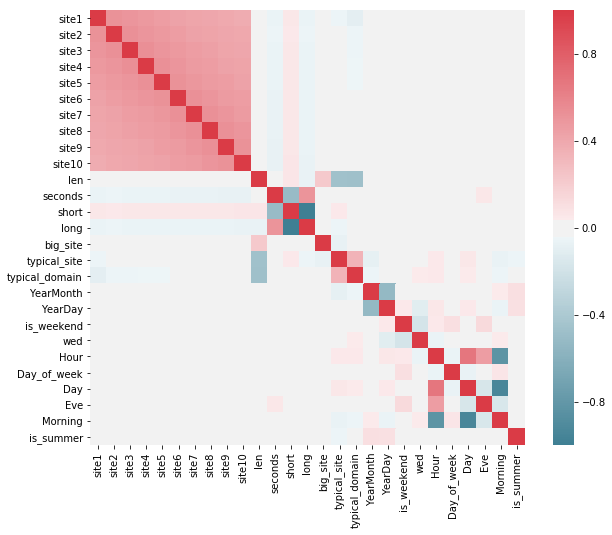

In [40]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.drop('Night',axis=1).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

In [53]:
train_df.head(5)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


In [65]:
start = df['YearMonth'][:idx_split].values
startday = df['YearDay'][:idx_split].values
y_tr = train_df['target'].astype('int').values

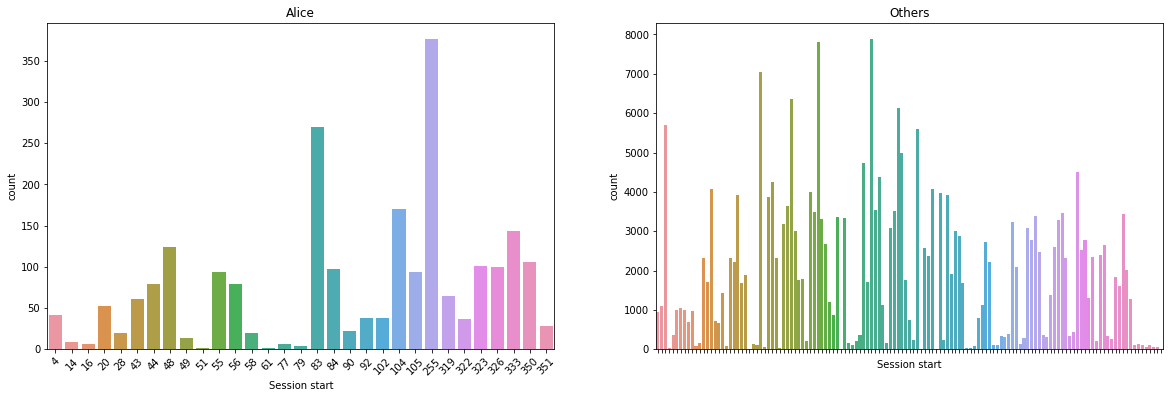

In [68]:
plt.subplots(1, 2, figsize = (20, 6)) 

plt.subplot(1, 2, 1)
chart = sns.countplot(startday[y_tr == 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Alice")
plt.xlabel('Session start')
          
plt.subplot(1, 2, 2)
chart = sns.countplot(startday[y_tr == 0])
chart.set(xticklabels=[])
plt.title('Others')
plt.xlabel('Session start');

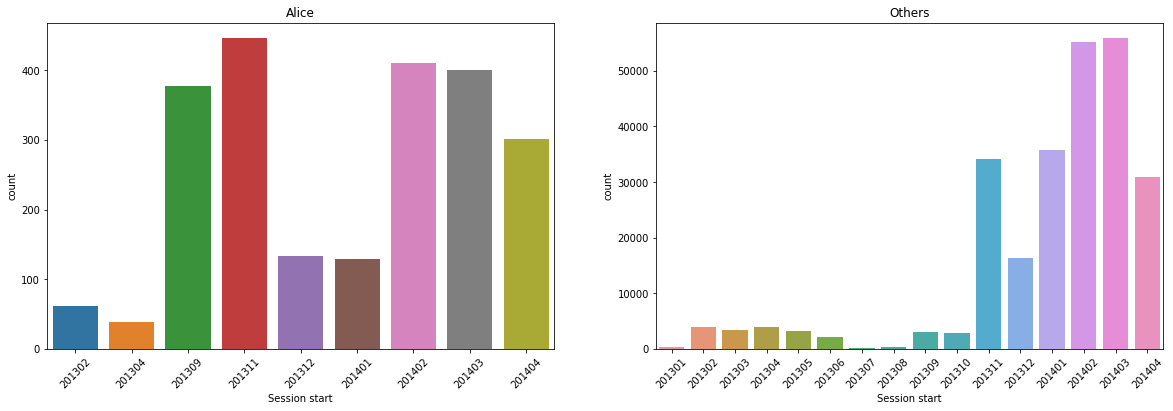

In [66]:
plt.subplots(1, 2, figsize = (20, 6)) 

plt.subplot(1, 2, 1)
chart = sns.countplot(start[y_tr == 1])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title("Alice")
plt.xlabel('Session start')
          
plt.subplot(1, 2, 2)
chart = sns.countplot(start[y_tr == 0])
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.title('Others')
plt.xlabel('Session start');

In [ ]:
#Места для улучшения полно, начиная от очевидной работы с feature importance и 
#заканчивая такими мелочами, как взять милисекунды вместо секунд. Но на это нужно больше времени.
#Спасибо за просмотр и оценку коллегам с курса! :) 